<a target="_blank" href="https://colab.research.google.com/github/balint-kiraly/predict-ai-model-runtime.git">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import os
from collections import defaultdict
from pathlib import Path
from tqdm.notebook import tqdm
import random

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from seaborn import JointGrid

import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import kendalltau

In [2]:
# Paths
DATA_ROOT = Path("/kaggle/input/predict-ai-model-runtime/npz_all/npz")

SAMPLE_GRAPHS_PER_SPLIT = 1000
MAX_CONFIGS_PER_GRAPH = None 

In [3]:
import glob
if not DATA_ROOT.exists():
    print('WARNING: DATA_ROOT does not exist. Please download/unzip the dataset under', DATA_ROOT)
else:
    train_files = glob.glob(str(DATA_ROOT / '**' / 'train' / '*.npz'), recursive=True)
    valid_files = glob.glob(str(DATA_ROOT / '**' / 'valid' / '*.npz'), recursive=True)
    test_files  = glob.glob(str(DATA_ROOT / '**' / 'test' / '*.npz'), recursive=True)
    print(f'Found: {len(train_files):,} train files, {len(valid_files):,} valid files, {len(test_files):,} test files')
    # show some example paths
    for p in (train_files[:3] if len(train_files)>0 else []):
        print(' -', p)

Found: 6,244 train files, 730 valid files, 894 test files
 - /kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla/train/retinanet.4x4.fp32_-431a58cc30e72ec6.npz
 - /kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla/train/retinanet.2x2.fp32_-4e825b910a64b27e.npz
 - /kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla/train/shapemask.4x4.fp32_46bb40f02a367b42.npz


In [4]:
def inspect_npz(path):
    data = np.load(path)
    print('File:', path)
    for k in data.files:
        v = data[k]
        shape = getattr(v, "shape", None)
    dtype = getattr(v, "dtype", None)
    print(f"{k:<20} shape={str(shape):<20} dtype={dtype} type={type(v).__name__}")
    return data

sample_path = None
if DATA_ROOT.exists():
    sample_list = train_files if len(train_files)>0 else (valid_files if len(valid_files)>0 else test_files)
    if len(sample_list)>0:
        sample_path = sample_list[0]

if sample_path:
    data = inspect_npz(sample_path)
else:
    print('No sample file found. Please set DATA_ROOT to the folder with unzipped .npz files.')

File: /kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla/train/retinanet.4x4.fp32_-431a58cc30e72ec6.npz
config_runtime_normalizers shape=(1537,)              dtype=int64 type=ndarray


Scanning sample graphs:   0%|          | 0/1000 [00:00<?, ?it/s]

Node count statistics (sample):


count     1000.000000
mean       753.998000
std       3433.310622
min          2.000000
25%         18.000000
50%         36.000000
75%         66.000000
max      43615.000000
dtype: float64

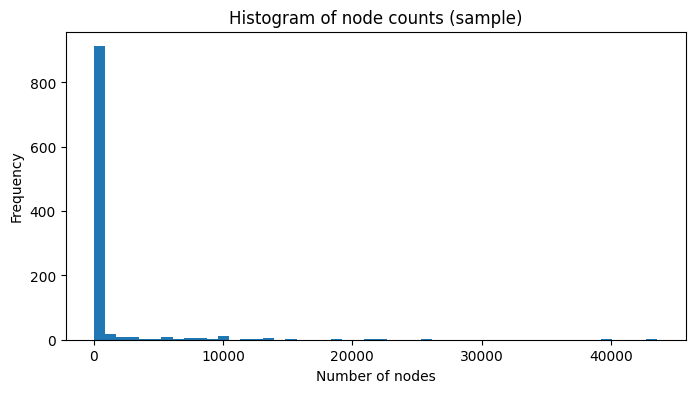

Sampled graphs total configs (sum of config_runtime lengths): 6186084
Example graph configs: 6986


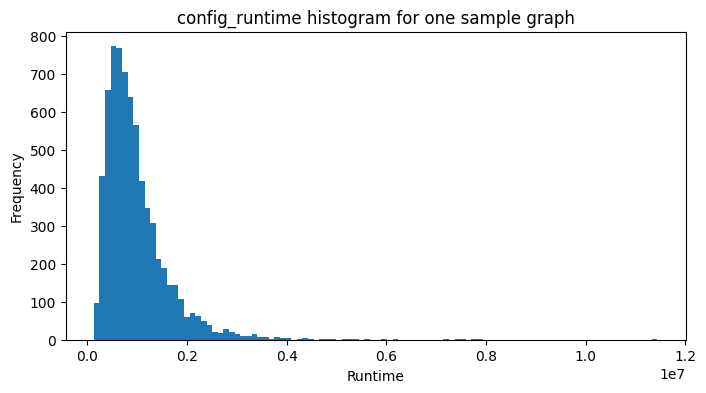

In [5]:
if DATA_ROOT.exists() and len(train_files)>0:
    sample_n = SAMPLE_GRAPHS_PER_SPLIT if SAMPLE_GRAPHS_PER_SPLIT is not None else len(train_files)
    sample_paths = random.sample(train_files, min(len(train_files), sample_n))
    node_counts = []
    edge_counts = []
    total_configs = 0
    for p in tqdm(sample_paths, desc='Scanning sample graphs'):
        d = np.load(p)
        n_nodes = d['node_feat'].shape[0]
        # edge_index may be shape (E,2) or (2,E)
        ei = d['edge_index']
        if ei.ndim==2 and ei.shape[1]==2:
            n_edges = ei.shape[0]
        elif ei.ndim==2 and ei.shape[0]==2:
            n_edges = ei.shape[1]
        else:
            n_edges = ei.size
        node_counts.append(n_nodes)
        edge_counts.append(n_edges)
        # try to count configs
        if 'config_runtime' in d.files:
            total_configs += int(d['config_runtime'].shape[0])
    import pandas as pd
    s = pd.Series(node_counts)
    print('Node count statistics (sample):')
    display(s.describe())
    plt.figure(figsize=(8,4))
    plt.hist(node_counts, bins=50)
    plt.title('Histogram of node counts (sample)')
    plt.xlabel('Number of nodes')
    plt.ylabel('Frequency')
    plt.show()
    print('Sampled graphs total configs (sum of config_runtime lengths):', total_configs)
    # Plot runtime histogram for the very first sample graph's config_runtime if present
    d0 = np.load(sample_paths[0])
    if 'config_runtime' in d0.files:
        runtimes = np.array(d0['config_runtime'])
        print('Example graph configs:', runtimes.shape[0])
        plt.figure(figsize=(8,4))
        plt.hist(runtimes, bins=100)
        plt.title('config_runtime histogram for one sample graph')
        plt.xlabel('Runtime')
        plt.ylabel('Frequency')
        plt.show()
else:
    print('Skipping EDA: dataset not found.')



In [6]:
def process_split(file_paths, split_name='train', sample_limit=SAMPLE_GRAPHS_PER_SPLIT, max_configs_per_graph=MAX_CONFIGS_PER_GRAPH):
    """Convert a list of .npz files into a pandas DataFrame (one row per config).
    This is memory-heavy; use sample_limit to restrict the number of graphs processed."""
    rows = []
    paths = file_paths
    if sample_limit is not None and len(paths) > sample_limit:
        paths = random.sample(paths, sample_limit)
    print(f'Processing {len(paths)} graphs for split {split_name}')
    for p in tqdm(paths, desc=f'Process {split_name}'):
        d = np.load(p)
        n_nodes = int(d['node_feat'].shape[0])
        ei = d['edge_index']
        if ei.ndim==2 and ei.shape[1]==2:
            n_edges = int(ei.shape[0])
        elif ei.ndim==2 and ei.shape[0]==2:
            n_edges = int(ei.shape[1])
        else:
            n_edges = int(ei.size)
        # retrieve configs
        # Several datasets use different keys: prefer 'config_feat' then 'node_config_feat'
        cfg_feat = None
        if 'config_feat' in d.files:
            cfg_feat = d['config_feat']
        elif 'node_config_feat' in d.files:
            # node_config_feat may have shape (c, nc, feat)
            node_cf = d['node_config_feat']
            # reduce to per-config summary (mean over configurable nodes)
            if node_cf.ndim==3:
                cfg_feat = node_cf.mean(axis=1)
            else:
                cfg_feat = node_cf
        else:
            cfg_feat = None
        runtimes = d['config_runtime'] if 'config_runtime' in d.files else None
        if runtimes is None:
            continue
        ccount = runtimes.shape[0]
        if max_configs_per_graph is not None:
            ccount = min(ccount, max_configs_per_graph)
        # process each config (careful: may be huge)
        for ci in range(ccount):
            r = {
                'graph_path': str(p),
                'n_nodes': n_nodes,
                'n_edges': n_edges,
                'config_idx': int(ci),
                'runtime': float(runtimes[ci])
            }
            # handle cfg_feat
            if cfg_feat is not None:
                try:
                    cf = cfg_feat[ci]
                except Exception:
                    # fallback: if cfg_feat is 1D of length num_configs
                    cf = cfg_feat
                cf = np.array(cf)
                if cf.ndim==1:
                    # add each element as column
                    for k_idx, val in enumerate(cf.tolist()):
                        r[f'cfg_{k_idx}'] = float(val)
                else:
                    # higher dim -> add mean/std per last axis
                    mean = cf.mean(axis=0)
                    std = cf.std(axis=0)
                    for k_idx, val in enumerate(mean.tolist()):
                        r[f'cfg_mean_{k_idx}'] = float(val)
                    for k_idx, val in enumerate(std.tolist()):
                        r[f'cfg_std_{k_idx}'] = float(val)
            rows.append(r)
    if len(rows)==0:
        print('No rows created for', split_name)
        return pd.DataFrame()
    df = pd.DataFrame(rows)
    return df

# Example usage (will process sampled graphs only):
prepared_train = None
prepared_valid = None
prepared_test = None
if DATA_ROOT.exists():
    prepared_train = process_split(train_files, 'train', sample_limit=SAMPLE_GRAPHS_PER_SPLIT, max_configs_per_graph=MAX_CONFIGS_PER_GRAPH)
    prepared_valid = process_split(valid_files, 'valid', sample_limit=200, max_configs_per_graph=MAX_CONFIGS_PER_GRAPH)
    prepared_test  = process_split(test_files,  'test',  sample_limit=200, max_configs_per_graph=MAX_CONFIGS_PER_GRAPH)
    print('Prepared shapes: ', (prepared_train.shape if prepared_train is not None else None), (prepared_valid.shape if prepared_valid is not None else None), (prepared_test.shape if prepared_test is not None else None))

Processing 1000 graphs for split train


Process train:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing 200 graphs for split valid


Process valid:   0%|          | 0/200 [00:00<?, ?it/s]

Processing 200 graphs for split test


Process test:   0%|          | 0/200 [00:00<?, ?it/s]

Prepared shapes:  (6138177, 29) (1287975, 29) (299484, 29)


In [7]:
SPLIT = ["train", "valid", "test"]

In [8]:
def summarize_npz_structure(root: Path, optim: str, limit=100):
    """Collect metadata about npz compiler files (lightweight)."""
    rows = []
    count = 0
    for split in SPLIT:
        dir_path = root / optim / "xla" / "default" / split
        if not dir_path.exists():
            continue
        for f in os.listdir(dir_path):
            if not f.endswith(".npz"): continue
            npz = dict(np.load(dir_path/f))
            n_nodes = npz["node_feat"].shape[0]
            n_edges = npz["edge_index"].shape[1]
            mean_feat = np.mean(npz["node_feat"], axis=0)
            rows.append([optim, split, n_nodes, n_edges, mean_feat[0], mean_feat[1]])
            count += 1
            if count >= limit:
                break
    return pd.DataFrame(rows, columns=["optim", "split", "n_nodes", "n_edges", "feat0", "feat1"])

layout_df = summarize_npz_structure(DATA_ROOT, "layout")
tile_df = summarize_npz_structure(DATA_ROOT, "tile")
df_2 = pd.concat([layout_df, tile_df], ignore_index=True)
df_2.head()


/tmp/ipykernel_38/147466731.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_2 = pd.concat([layout_df, tile_df], ignore_index=True)


,optim,split,n_nodes,n_edges,feat0,feat1
0,layout,train,5605,2,0.058519,0.0
1,layout,train,15022,2,0.031287,0.0
2,layout,train,24790,2,0.061597,0.0
3,layout,train,5358,2,0.014744,0.0
4,layout,train,21335,2,0.033091,0.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


           feat0  feat1
count  76.000000   76.0
mean    0.041396    0.0
std     0.016643    0.0
min     0.003600    0.0
25%     0.031228    0.0
50%     0.038062    0.0
75%     0.058523    0.0
max     0.071247    0.0


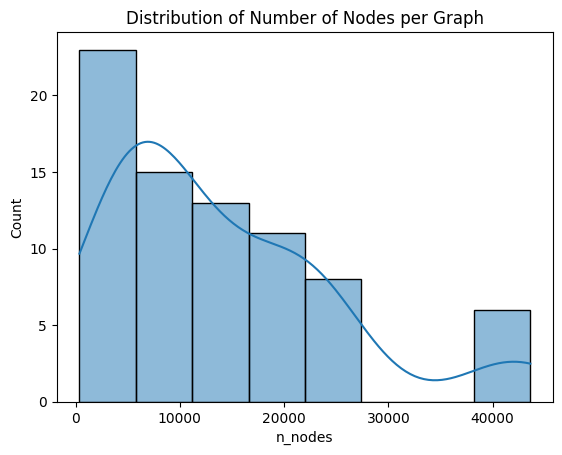

In [9]:
print(df_2.describe())

sns.histplot(df_2["n_nodes"], kde=True)
plt.title("Distribution of Number of Nodes per Graph")
plt.show()

In [10]:
OUT_DIR = Path('/kaggle/working/')
OUT_DIR.mkdir(parents=True, exist_ok=True)
if 'prepared_train' in globals() and prepared_train is not None and not prepared_train.empty:
    train_path = OUT_DIR / 'prepared_train.parquet'
    prepared_train.to_parquet(train_path, index=False)
    print('Wrote', train_path)
if 'prepared_valid' in globals() and prepared_valid is not None and not prepared_valid.empty:
    valid_path = OUT_DIR / 'prepared_valid.parquet'
    prepared_valid.to_parquet(valid_path, index=False)
    print('Wrote', valid_path)
if 'prepared_test' in globals() and prepared_test is not None and not prepared_test.empty:
    test_path = OUT_DIR / 'prepared_test.parquet'
    prepared_test.to_parquet(test_path, index=False)
    print('Wrote', test_path)

Wrote /kaggle/working/prepared_train.parquet
Wrote /kaggle/working/prepared_valid.parquet
Wrote /kaggle/working/prepared_test.parquet


Loaded 6138177 config rows.
Split Sizes -> Train: 5207190, Valid: 451699, Local Test: 479288
Training XGBoost...
[0]	validation_0-rmse:1.57139	validation_1-rmse:1.72919
[100]	validation_0-rmse:0.71651	validation_1-rmse:0.89472
[200]	validation_0-rmse:0.64009	validation_1-rmse:0.87349
[229]	validation_0-rmse:0.62793	validation_1-rmse:0.87359

FINAL RESULT -> Local Test Kendall's Tau: 0.5023


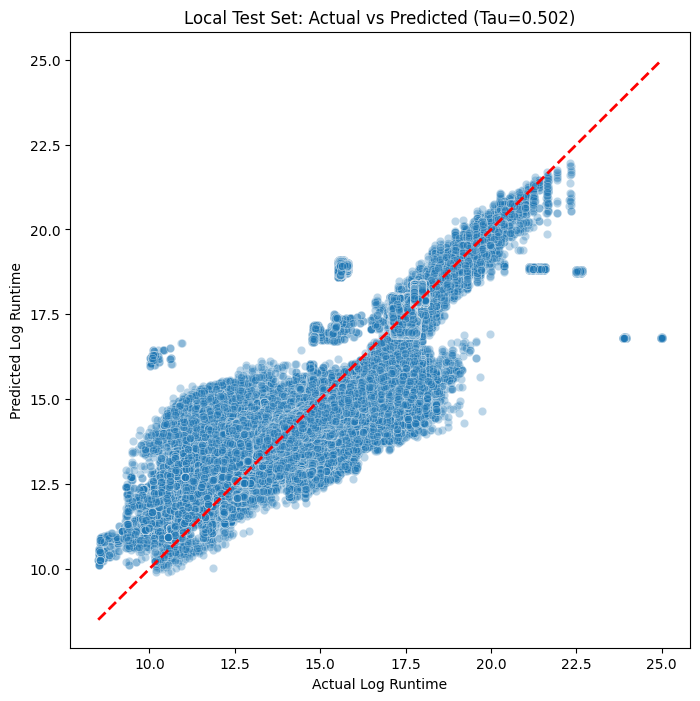

In [12]:
df_full = pd.read_parquet('/kaggle/working/prepared_train.parquet')
print(f"Loaded {len(df_full)} config rows.")

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = df_full['graph_path']

train_idx, temp_idx = next(splitter.split(df_full, groups=groups))
df_train = df_full.iloc[train_idx].copy()
df_temp = df_full.iloc[temp_idx].copy()

splitter_2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
valid_idx, test_idx = next(splitter_2.split(df_temp, groups=df_temp['graph_path']))
df_valid = df_temp.iloc[valid_idx].copy()
df_local_test = df_temp.iloc[test_idx].copy()

print(f"Split Sizes -> Train: {len(df_train)}, Valid: {len(df_valid)}, Local Test: {len(df_local_test)}")

metadata = ['graph_path', 'config_idx', 'runtime', 'log_runtime']
for df in [df_train, df_valid, df_local_test]:
    df['log_runtime'] = np.log1p(df['runtime'])

features = [c for c in df_train.columns if c not in metadata]
X_train, y_train = df_train[features], df_train['log_runtime']
X_valid, y_valid = df_valid[features], df_valid['log_runtime']
X_test, y_test   = df_local_test[features], df_local_test['log_runtime']

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1,
    early_stopping_rounds=20
)

print("Training XGBoost...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100
)

def get_tau(df, model, feats):
    preds = model.predict(df[feats])
    df = df.copy()
    df['pred'] = preds
    taus = []
    for _, grp in df.groupby('graph_path'):
        if len(grp) > 1:
            t, _ = kendalltau(grp['runtime'], grp['pred'])
            if not np.isnan(t): taus.append(t)
    return np.mean(taus)

test_tau = get_tau(df_local_test, model, features)
print(f"\nFINAL RESULT -> Local Test Kendall's Tau: {test_tau:.4f}")

plt.figure(figsize=(8, 8))
test_preds = model.predict(X_test)
sns.scatterplot(x=y_test, y=test_preds, alpha=0.3)

low = min(y_test.min(), test_preds.min())
high = max(y_test.max(), test_preds.max())
plt.plot([low, high], [low, high], 'r--', lw=2)
plt.title(f"Local Test Set: Actual vs Predicted (Tau={test_tau:.3f})")
plt.xlabel("Actual Log Runtime")
plt.ylabel("Predicted Log Runtime")
plt.show()

In [15]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import xgboost as xgb


train_cols = X_train.columns.tolist()

submission_rows = []

print(f"Starting inference on {len(test_files)} test graphs...")


def get_id_from_path(p):
    parts = Path(p).parts
    filename = Path(p).stem
    
    if 'tile' in parts:
        return f"tile:xla:{filename}"
    else:
        source = 'nlp' if 'nlp' in parts else 'xla'
        search = 'random' if 'random' in parts else 'default'
        return f"layout:{source}:{search}:{filename}"

# Iterate over all test files
for p in tqdm(test_files, desc="Generating Submission"):
    try:
        d = np.load(p)
        
        cfg_feat = None
        if 'config_feat' in d.files:
            cfg_feat = d['config_feat']
        elif 'node_config_feat' in d.files:
            node_cf = d['node_config_feat']
            if node_cf.ndim == 3:
                cfg_feat = node_cf.mean(axis=1)
            else:
                cfg_feat = node_cf
        
        if cfg_feat is not None:
            num_configs = cfg_feat.shape[0]
        else:
            continue
            
        if num_configs == 0:
            continue

        # Construct DataFrame for this graph's configs
        n_nodes = int(d['node_feat'].shape[0])
        ei = d['edge_index']
        if ei.ndim == 2 and ei.shape[1] == 2:
            n_edges = int(ei.shape[0])
        elif ei.ndim == 2 and ei.shape[0] == 2:
            n_edges = int(ei.shape[1])
        else:
            n_edges = int(ei.size)
            
        graph_data = {
            'n_nodes': [n_nodes] * num_configs,
            'n_edges': [n_edges] * num_configs,
        }
        
        # Add config specific features
        cfg_feat = np.array(cfg_feat)
        if cfg_feat.ndim == 2:
            for k in range(cfg_feat.shape[1]):
                col_name = f'cfg_{k}'
                graph_data[col_name] = cfg_feat[:, k]
        
        df_graph = pd.DataFrame(graph_data)
        
        # Align columns with Training Data
        for col in train_cols:
            if col not in df_graph.columns:
                df_graph[col] = 0
        
        X_test_graph = df_graph[train_cols]
        
        pred_scores = model.predict(X_test_graph)
        
        ranked_indices = np.argsort(pred_scores)
        ranked_str = ";".join(map(str, ranked_indices))
        
        row_id = get_id_from_path(p)

        submission_rows.append({'ID': row_id, 'TopConfigs': ranked_str})
        
    except Exception as e:
        print(f"Error processing {p}: {e}")
        continue

if submission_rows:
    sub_df = pd.DataFrame(submission_rows)
    sub_path = OUT_DIR / 'submission.csv'
    sub_df.to_csv(sub_path, index=False)
    print(f"Success! Submission file written to {sub_path}")
    print(sub_df.head())
else:
    print("No submission rows generated.")

Starting inference on 894 test graphs...


Generating Submission:   0%|          | 0/894 [00:00<?, ?it/s]

Success! Submission file written to /kaggle/working/submission.csv
                                          ID  \
0  tile:xla:04ae9238c653f8ae08f60f2c03615f0b   
1  tile:xla:85d157d3b1848c6b6fff0c633876e2e6   
2  tile:xla:862900d42397d03be2762e1bf7518bea   
3  tile:xla:0afa527a7022415fda1dd69d11e908a4   
4  tile:xla:2d09e3ab92e184c561abaf8d9efe7b87   

                                          TopConfigs  
0  686;90;285;88;385;658;273;659;64;330;509;39;75...  
1  1806;7122;5560;4526;4731;169;735;5821;5409;281...  
2  736;1563;1130;216;415;592;1208;0;744;695;205;5...  
3  178;23;69;122;34;212;210;158;64;109;120;38;25;...  
4  157;231;233;262;235;77;5;63;196;207;173;95;33;...  
